In [1]:
import cv2
import toml
import sys
import os
import time
import json
import numpy as np
from IPython.display import display, Image

sys.path.append(os.path.abspath("data_management"))
sys.path.append(os.path.abspath("onnx_models"))

import data_preprocessing as dprep
import data_postprocessing as dpostp
import onnx_inference as onnx_inf

from fpgaconvnet_driver import Partition

%matplotlib inline

In [2]:
yolo_cfg = toml.load('yolov5n.toml')
imgsz = yolo_cfg['input_data']['imgsz']
conf_thres = yolo_cfg['predictor']['conf_thres']
iou_thres = yolo_cfg['predictor']['iou_thres']
classes = yolo_cfg['predictor']['classes']
if not classes:
    classes = None
onnx_model_path = yolo_cfg['onnx_model_path']
visualize = yolo_cfg['visualize']
out_img_path = yolo_cfg['out_img_path']
input_source = yolo_cfg['source']

In [3]:
_, _, session, output_names = onnx_inf.load_model(onnx_model_path)
stride = 32
names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

In [4]:
#########################
### fpgaConvNet Setup ###
#########################

# initialise partition
partition = Partition("hardware/openhw.bit", 5) 

# add input buffers
partition.add_input_buffer(0, 0, [320, 320, 3], bp=8)

# add output buffers
partition.add_output_buffer(2, 2, [40, 40, 256], bp=10, streams=2)
partition.add_output_buffer(3, 3, [20, 20, 256], bp=10, streams=2)
partition.add_output_buffer(4, 4, [10, 10, 256], bp=10, streams=2)

# create fifos
partition.add_fifo(0, 0, 2, 40*40*64 , burst=6400)
partition.add_fifo(1, 1, 1, 20*20*128, burst=6400)

# # setup hardware
partition.reset_hardware()
# p.start_hardware()  

# get the lookup table for the weights
with open("weight-lookup.json", "r") as f:
    lookup = json.load(f)

# iterate over the weights
for layer, idx in lookup.items():

    # allocate weights and load them
    start_time = time.perf_counter() 
    partition.reload_weights(idx, f"weights/{layer}.dat")
    pred_time = (time.perf_counter() - start_time)*1000
    print(f"[{idx}] {layer} loaded! ({pred_time:.2f} ms)")

# setup hardware
partition.reset_hardware()
partition.start_hardware()  

[0] conv_0 loaded! (6.41 ms)
[1] conv_2 loaded! (16.32 ms)
[2] conv_4 loaded! (2.59 ms)
[3] conv_11 loaded! (332.62 ms)
[4] conv_6 loaded! (1249.35 ms)
[5] conv_8 loaded! (8.90 ms)
[6] conv_14 loaded! (4.00 ms)
[7] conv_16 loaded! (60.64 ms)
[8] conv_18 loaded! (7.12 ms)
[9] conv_30 loaded! (11.26 ms)
[10] conv_20 loaded! (8.35 ms)
[11] conv_22 loaded! (30.13 ms)
[12] conv_25 loaded! (4.09 ms)
[13] conv_27 loaded! (33.16 ms)
[14] conv_33 loaded! (13.48 ms)
[15] conv_35 loaded! (224.41 ms)
[16] conv_37 loaded! (30.77 ms)
[17] conv_54 loaded! (30.90 ms)
[18] conv_39 loaded! (17.69 ms)
[19] conv_41 loaded! (113.25 ms)
[20] conv_44 loaded! (19.75 ms)
[21] conv_46 loaded! (114.34 ms)
[22] conv_49 loaded! (17.54 ms)
[23] conv_51 loaded! (116.50 ms)
[24] conv_57 loaded! (54.66 ms)
[25] conv_59 loaded! (820.31 ms)
[26] conv_61 loaded! (102.22 ms)
[27] conv_68 loaded! (103.41 ms)
[28] conv_63 loaded! (55.47 ms)
[29] conv_65 loaded! (427.19 ms)
[30] conv_71 loaded! (196.62 ms)
[31] conv_73 loade

In [5]:
# method for executing the accelerator
def run_fpgaconvnet(partition, input_data):
    
    # assign the input data
    data = np.moveaxis(input_data, 0, -1).flatten() * (2**partition.input_bp[0])
    partition.input_buffers[0][:] = data.astype(np.int16)
    
    # start all transfers
    start_time = time.perf_counter() 

    # send in the input data
    partition.send_dma(0)

    # recieve data out
    partition.recv_dma(2)
    partition.recv_dma(3)
    partition.recv_dma(4)

    # start the FIFOs
    partition.start_fifo([0, 1])
    
    # wait for output DMAs to finish
    partition.wait_dma(0, recv=False)
    partition.wait_dma(2, send=False)
    partition.wait_dma(3, send=False)
    partition.wait_dma(4, send=False)

    # print statement
    pred_time = (time.perf_counter() - start_time)*1000
    
    # reset the FIFO
    partition.reset_fifo_dma()

    # get the outputs
    output_0 = np.moveaxis(np.reshape(partition.output_buffers[2], 
        partition.output_shape[2]), -1, 0).astype(np.float32) / float(2**partition.output_bp[2])
    output_1 = np.moveaxis(np.reshape(partition.output_buffers[3],
        partition.output_shape[3]), -1, 0).astype(np.float32) / float(2**partition.output_bp[3])
    output_2 = np.moveaxis(np.reshape(partition.output_buffers[4],
        partition.output_shape[4]), -1, 0).astype(np.float32) / float(2**partition.output_bp[4])
    
    return output_0, output_1, output_2, pred_time

name 'cap' is not defined


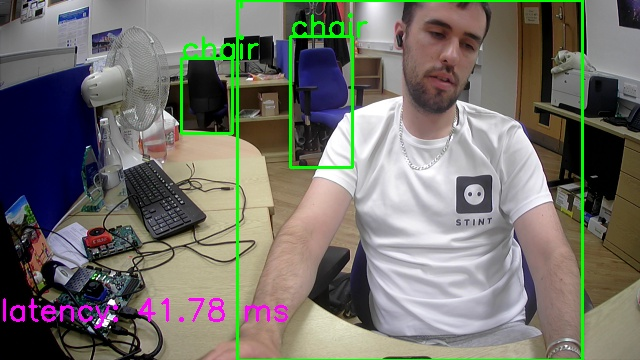

In [ ]:
try:
    cap.release()
    cap.destroyAllWindows()
except Exception as e:
    print(e)
    pass

if input_source == 'webcam':
    cap = cv2.VideoCapture(0) 
    display_handle=display(None, display_id=True)
else:
    cap = cv2.VideoCapture(input_source)

while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Check that frame is not empty
    if ret:
        orig_img = frame.copy()
        
        # perform pre-processing
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = dprep.img_preprocess(img, imgsz, stride)
        
        # run fpgaconvnet
        out0, out1, out2, pred_time = run_fpgaconvnet(partition, img[0])
        
        # run the onnx head
        predictions = session.run(output_names, {
            "/model.24/m.0/Conv_output_0": np.expand_dims(out0[:255,:,:], axis=0),
            "/model.24/m.1/Conv_output_0": np.expand_dims(out1[:255,:,:], axis=0),
            "/model.24/m.2/Conv_output_0": np.expand_dims(out2[:255,:,:], axis=0),
        })[0]        
                
        predictions = dpostp.yolo_nms(predictions, conf_thres, iou_thres, classes)
        
        for pred in predictions:

            pred[:, :4] = dpostp.scale_boxes((imgsz, imgsz), pred[:, :4], orig_img.shape).round()

            for p in pred:
                if visualize:
                    cv2.rectangle(orig_img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), (0, 255, 0), 2)
                    cv2.putText(orig_img, names[int(p[5])], (int(p[0]), int(p[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # add the time for inference
        cv2.putText(orig_img, f"latency: {pred_time:.2f} ms", (0, imgsz), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)
                
        if visualize:
            _, disp_img = cv2.imencode('.jpeg', orig_img)
            display_handle.update(Image(data=disp_img.tobytes()))
                        
    else:
        break
        
try:
    cap.release()
    cap.destroyAllWindows()
    display_handle.update(None)
except Exception as e:
    print(e)
    pass